# Data Preprocessing

In [ ]:
!pip install transformers torch einops
!pip install 'numpy<2'


In [1]:
from transformers import AutoModel

# Initialize the model
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

texts = [
    "Follow the white rabbit.",  # English
    "Sigue al conejo blanco.",  # Spanish
    "Suis le lapin blanc.",  # French
    "跟着白兔走。",  # Chinese
    "اتبع الأرنب الأبيض.",  # Arabic
    "Folge dem weißen Kaninchen.",  # German
]

# When calling the `encode` function, you can choose a `task` based on the use case:
# 'retrieval.query', 'retrieval.passage', 'separation', 'classification', 'text-matching'
# Alternatively, you can choose not to pass a `task`, and no specific LoRA adapter will be used.
embeddings = model.encode(texts, task="text-matching")

# Compute similarities
print(embeddings[0] @ embeddings[1].T)


0.70863205


In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

task = "retrieval.query"
embeddings = model.encode(
    ["What is the weather like in Berlin today?"],
    task=task,
    prompt_name=task,
)

# View the embeddings
print("Embedding shape:", embeddings.shape)
print("Embedding type:", type(embeddings))
print("\nFirst 10 values of the embedding vector:")
print(embeddings[0][:10])
print("\nEmbedding statistics:")
print(f"Min: {np.min(embeddings):.4f}")
print(f"Max: {np.max(embeddings):.4f}")
print(f"Mean: {np.mean(embeddings):.4f}")

Embedding shape: (1, 1024)
Embedding type: <class 'numpy.ndarray'>

First 10 values of the embedding vector:
[-0.08290821  0.06265671 -0.04169067  0.0327671   0.06865494 -0.05068411
 -0.01948197 -0.05885065  0.04949485  0.04762538]

Embedding statistics:
Min: -0.1236
Max: 0.1221
Mean: 0.0003


In [3]:
import pandas as pd

# Load data
df = pd.read_excel("/Users/vinitavader/Desktop/WJC/data/P2_merged_data.xlsx")
# Filter to keep only good responses (where flag = 1) as specified in the pre-registration
df = df[df['Flag.(0.for.bad.response.1.for.good.response)'] == 1]
# Reset index if needed
df = df.reset_index(drop=True)

# Define prompts
prompts = [
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    "3. What were you thinking when you first encountered this difficult decision?",
    "4. What were you feeling when you first encountered this difficult decision?",
    "5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "6. In what ways did this difficult decision affect your life?",
    "7. Is there anything else you would like to share about this difficult decision?"
]

# Merge original-language responses
def merge_open_responses_original(df):
    """
    Merge original-language open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}_original' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}_original'. The resulting values are stored 
    in 'Open_{i}_original'. Additionally, a new column 'open_type_original' is created to indicate the source 
    ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing original-language open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged original-language responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}_original' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}_original' for i in range(1, 8)]
    target = [f'Open_{i}_original' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_original'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Merge English-translated responses
def merge_open_responses_en(df):
    """
    Merge English-translated open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}'. The results are stored in 
    'Open_{i}_en'. A new column 'open_type_en' indicates the response source ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing English-translated open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged English responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}_en' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}_en' for i in range(1, 8)]
    target = [f'Open_{i}_en' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_en'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Concatenate prompt + response strings
def concatenate_open_responses(df, prefix):
    """
    Concatenate prompt–response pairs into unified narrative fields for open-ended survey responses.

    Constructs two string fields:
    1. 'all_open_{prefix}' — a full concatenation of all 7 prompts with their corresponding responses.
    2. 'Open_Q1_2_{prefix}' — a partial concatenation using only the first two prompts and responses.

    Prompts are fixed; responses are drawn from 'Open_{i}_{prefix}' for i in 1–7. Missing responses 
    are replaced with 'No response.'. Excess whitespace is removed.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with open-ended response columns already merged and labeled.
    prefix : str
        Column suffix indicating response language/context (e.g., 'original' or 'en').

    Returns
    -------
    pandas.DataFrame
        DataFrame with two new columns containing concatenated prompt–response strings.
    """
    response_cols = [f'Open_{i}_{prefix}' for i in range(1, 8)]

    # Full concatenated text
    df[f'all_open_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>') + " " +
        prompts[2] + " " + df[response_cols[2]].fillna('<NA>') + " " +
        prompts[3] + " " + df[response_cols[3]].fillna('<NA>') + " " +
        prompts[4] + " " + df[response_cols[4]].fillna('<NA>') + " " +
        prompts[5] + " " + df[response_cols[5]].fillna('<NA>') + " " +
        prompts[6] + " " + df[response_cols[6]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    # Q1 + Q2
    df[f'Open_Q1_2_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

# Execute full pipeline
df = (
    df
    .pipe(merge_open_responses_original)
    .pipe(merge_open_responses_en)
    .loc[lambda d: d[[f'Open_{i}_original' for i in range(1, 8)]].notna().any(axis=1)]
    .reset_index(drop=True)
)

df = concatenate_open_responses(df, prefix='original')
df = concatenate_open_responses(df, prefix='en')

# Create versions of Q1+Q2 without prompt text
df['Open_Q1_2_original_noQ'] = (
    df['Open_1_original'].fillna('<NA>') + " " +
    df['Open_2_original'].fillna('<NA>')
).str.replace(r'\s+', ' ', regex=True).str.strip()

df['Open_Q1_2_en_noQ'] = (
    df['Open_1_en'].fillna('<NA>') + " " +
    df['Open_2_en'].fillna('<NA>')
).str.replace(r'\s+', ' ', regex=True).str.strip()

import re

def clean_text(text):
    """
    Remove unwanted artifacts from text using regex.

    Artifacts removed:
    - '&#xa' and '&#xa;'
    - 'xml:space="preserve"' and 'xml:space="preserve">'
    - '_x000D_'
    """
    if pd.isnull(text):
        return text
    return re.sub(r'(&#xa;?|xml:space="preserve">?|_x000D_)', '', text)

columns_to_clean = [ # this is all the text variables, group by type (original language or english translation)
    'Norm_Q_original', 'Open_1_original', 'Open_2_original', 'Open_3_original',
    'Open_4_original', 'Open_5_original', 'Open_6_original', 'Open_7_original',
    'Norm_Q_en', 'Open_1_en', 'Open_2_en', 'Open_3_en', 'Open_4_en',
    'Open_5_en', 'Open_6_en', 'Open_7_en', 'all_open_original',
    'Open_Q1_2_original', 'all_open_en', 'Open_Q1_2_en',
    'Open_Q1_2_original_noQ', 'Open_Q1_2_en_noQ'
]

df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)

df = df[df["Flag.(0.for.bad.response.1.for.good.response)"] == 1]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 77 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Duration..in.seconds.                          2197 non-null   float64
 1   ResponseId                                     2332 non-null   object 
 2   ID                                             2381 non-null   object 
 3   Language                                       2381 non-null   object 
 4   Country                                        2381 non-null   object 
 5   Flag.(0.for.bad.response.1.for.good.response)  2381 non-null   int64  
 6   Norm_Q_original                                2165 non-null   object 
 7   Norm_Q_en                                      2163 non-null   object 
 8   Satis_Q                                        2365 non-null   object 
 9   Resolve_Q                                      2365 

/var/folders/_j/6kzq7zrd0xv15ptwq_tkwtq00000gn/T/ipykernel_82507/3881634399.py:174: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)


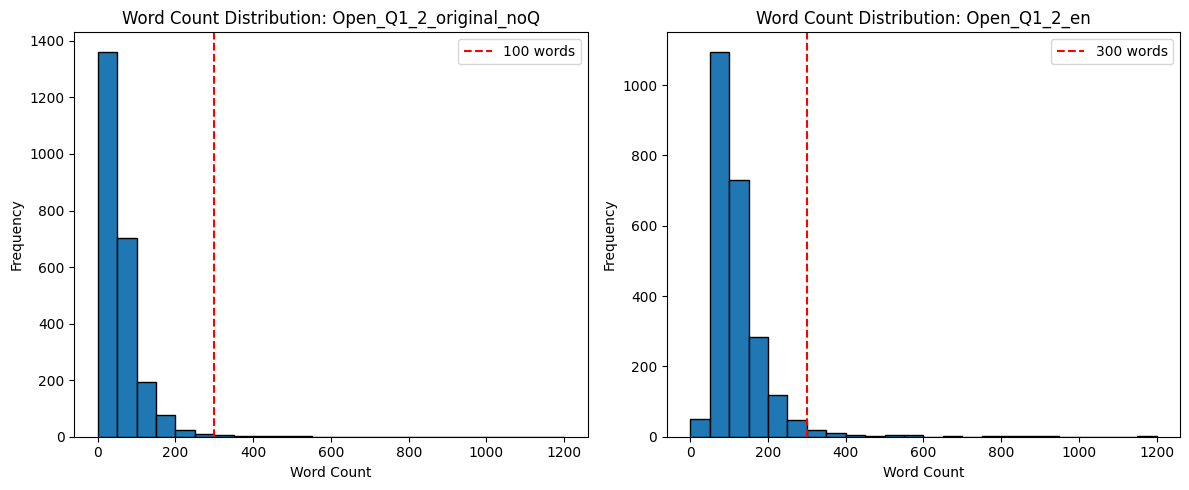

word_count_original_noQ: 11 responses over limit of words (1.39%)
word_count_en: 55 responses over limit of words (6.93%)


In [4]:
df[['Open_Q1_2_original_noQ', 'Open_Q1_2_en']].apply(lambda col: col.str.split().str.len())


df['word_count_original_noQ'], df['word_count_en'] = (
    df['Open_Q1_2_original_noQ'].str.split().str.len(),
    df['Open_Q1_2_en'].str.split().str.len()
)

import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, max(df['word_count_original_noQ'].max(), df['word_count_en'].max()) + 50, 50)

plt.figure(figsize=(12, 5))

# Histogram for original language
plt.subplot(1, 2, 1)
plt.hist(df['word_count_original_noQ'].dropna(), bins=bins, edgecolor='black')
plt.axvline(300, color='red', linestyle='--', label='100 words')
plt.title('Word Count Distribution: Open_Q1_2_original_noQ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# Histogram for English translation
plt.subplot(1, 2, 2)
plt.hist(df['word_count_en'].dropna(), bins=bins, edgecolor='black')
plt.axvline(300, color='red', linestyle='--', label='300 words')
plt.title('Word Count Distribution: Open_Q1_2_en')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

for col in ['word_count_original_noQ', 'word_count_en']:
    total = df[col].notna().sum()
    over_384 = (df[col] > 300).sum()
    pct_over_384 = over_384 / total * 300 if total > 0 else 0
    print(f"{col}: {over_384} responses over limit of words ({pct_over_384:.2f}%)")



# Embed text

In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os
from tqdm import tqdm

# --- token-based sliding windows ---
def chunk_text_by_tokens(text, tokenizer, window_size=128, overlap=64):
    """
    Split `text` into token windows of length `window_size`, overlapping by `overlap` tokens,
    using the model's tokenizer.
    """
    assert 0 <= overlap < window_size, "overlap must be in [0, window_size)"
    if text is None:
        text = ""
    # tokenize without adding special tokens so counts match the real content
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    if not token_ids:  # handle empty input: return one empty chunk
        return [""]

    step = window_size - overlap
    chunks = []
    for start in range(0, len(token_ids), step):
        window = token_ids[start : start + window_size]
        if not window:
            break
        # decode back to text for SentenceTransformer.encode
        chunk_text = tokenizer.decode(window, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        chunks.append(chunk_text)
        if start + window_size >= len(token_ids):
            break
    return chunks

def mean_pool_embeddings(embs):
    """
    L2-normalize each chunk embedding, average, then L2-normalize the pooled vector.
    """
    if len(embs) == 1:
        v = embs[0]
        # normalize single vector
        v = v / (np.linalg.norm(v) + 1e-12)
        return v
    # normalize per-chunk, then mean
    normed = [e / (np.linalg.norm(e) + 1e-12) for e in embs]
    pooled = np.mean(normed, axis=0)
    pooled = pooled / (np.linalg.norm(pooled) + 1e-12)
    return pooled

def compute_and_save_embeddings_sliding_meanpool(
    df,
    column_name,
    output_path,
    model,
    window_size=128,
    overlap=64,
    batch_size=64,
):
    """
    For each row: chunk by tokens (window_size, overlap), embed all chunks, mean-pool to one vector,
    save arrays {ids, embeddings} to .npz
    """
    ids = df["ID"].tolist()
    texts = df[column_name].fillna("").astype(str).tolist()
    tokenizer = model.tokenizer

    pooled_vectors = []
    dim = model.get_sentence_embedding_dimension()

    for text in tqdm(texts, desc=f"Embedding (ws={window_size}, ov={overlap})"):
        chunks = chunk_text_by_tokens(text, tokenizer, window_size=window_size, overlap=overlap)
        # encode all chunks for this document; normalize at the end (we normalize manually)
        chunk_embs = model.encode(
            chunks,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=False,  # we control normalization
        )
        pooled = mean_pool_embeddings(chunk_embs)
        pooled_vectors.append(pooled)

    embeddings = np.vstack(pooled_vectors).astype(np.float32)

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)
    print(f"Saved embeddings to: {output_path}")

# ---- usage ----
output_dir = './data/Embeddings/Wave 2/'
target_columns = ['Open_Q1_2_original_noQ']
model_names = ['jinaai/jina-embeddings-v3']

In [6]:

for model_name in model_names:
    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name, trust_remote_code=True)  # Added trust_remote_code
    
    for col in target_columns:
        model_id = model_name.split("/")[-1]
        output_path = os.path.join(output_dir, f'emb_{col}_{model_id}_ws128_ov64_meanpool.npz')
        
        print(f"Processing column: {col}")
        compute_and_save_embeddings_sliding_meanpool(
            df,
            column_name=col,
            output_path=output_path,
            model=model,
            window_size=128,
            overlap=64,
            batch_size=64  # adjust to your device
        )

Loading model: jinaai/jina-embeddings-v3
Processing column: Open_Q1_2_original_noQ


Embedding (ws=128, ov=64): 100%|██████████| 2381/2381 [02:40<00:00, 14.83it/s]


Saved embeddings to: ./data/Embeddings/Wave 2/emb_Open_Q1_2_original_noQ_jina-embeddings-v3_ws128_ov64_meanpool.npz


In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# LOCAL output directory: where to save embeddings on your machine. Example:
output_dir = './data/Embeddings/Wave 2/' # 

def compute_and_save_embeddings(df, column_name, output_path, model, batch_size=32):
    """Reusable function for vectorizing a text variable and saving the embeddings.

    Args:
        df (_type_): Pandas dataframe
        column_name (_type_): your text variable
        output_path (_type_): local on your computer or shared drive
        model (_type_): the text embedding model
        batch_size (int, optional): The number of documents to be embed at once. Device dependant. Defaults to 32.
    """
    texts = df[column_name].fillna('').astype(str).tolist()
    ids = df['ID'].tolist()
    embeddings = model.encode(
        texts, # a text variable
        batch_size=batch_size, # number of documents to vectorize per batch
        show_progress_bar=True
        )
    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)

# List of target columns and models
target_columns = ['Open_Q1_2_original_noQ'
                  ]
model_names = [
    'jinaai/jina-embeddings-v3'
]

# For each model and column pair, embed the documents with the model on your computer
for model_name in model_names:
    model = SentenceTransformer(model_name, trust_remote_code=True)
    for col in target_columns:
        model_id = model_name.split("/")[-1]
        output_path = os.path.join(output_dir, f'emb_{col}_{model_id}.npz')
        compute_and_save_embeddings(df, col, output_path, model=model, batch_size=32)

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# Output directory for storing embeddings
output_dir = './data/Embeddings/Wave 1/'

def compute_and_save_embeddings(df, column_name, output_path, model, batch_size=32, task='separation'):
    """Compute and save embeddings using a task-specific adapter."""
    texts = df[column_name].fillna('').astype(str).tolist()
    ids = df['ID'].tolist()
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        prompt_name=task,  # specify task-specific adapter
        max_length=1024,
        truncate_dim=768
    )
    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)

# Define target text columns
target_columns = ['Open_Q1_2_original_noQ']

# Load Jina model with support for remote code
model_name = 'jinaai/jina-embeddings-v3'
model = SentenceTransformer(model_name, trust_remote_code=True)
model_id = model_name.split("/")[-1]

# Compute embeddings for each column using the 'separation' task
for col in target_columns:
    output_path = os.path.join(output_dir, f'emb_{col}_{model_id}_separation.npz')
    compute_and_save_embeddings(df, col, output_path, model=model, batch_size=8, task='separation')


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

# Topic Modeling using Jinaai embeddings

In [26]:
import pandas as pd
import numpy as np
from bertopic.representation import MaximalMarginalRelevance # <-- Add this import
import tiktoken
import openai
import numpy as np
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import umap
import hdbscan

# --- Apply topic modeling pipeline ---

# 1. Load the documents

docs = df['Open_Q1_2_en_noQ'].astype(str)   # this version of the text, without question text, is used for ctf-idf


# 2. Load corresponding pre-computed Jina embeddings
file_path = './data/Embeddings/Wave 2/emb_Open_Q1_2_original_noQ_jina-embeddings-v3_ws128_ov64_meanpool.npz'
emb_data = np.load(file_path)
embeddings = emb_data['embeddings']

# Set global reproducibility seed
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

# Vectorizer and transformation model
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words="english") # remove stopwords here, but not before the embedding
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# 3. Define the representation model (ADD THIS BACK)
mmr = MaximalMarginalRelevance(diversity=0.3) # <-- Define mmr here

umap_model = umap.UMAP(
    n_components=4,     # tunable: (3 levels: 4-7)
    n_neighbors=15,     # tunable: (4 levels: 10-20)
    min_dist=0.3,       # tunable: (4 levels levels: .01, .3)
    metric='cosine',    
    random_state=seed
) 

# 4. HDBSCAN clustering
# Reference: 
# Implementation:

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=35,
    min_samples = 1, # 1 minimizes outliers
    metric='euclidean',
    cluster_selection_method='leaf',
    approx_min_span_tree=False, # must be off to have reproducibility
    prediction_data=True
)

# mmr - diversity value 

# 5. Define the BERTopic model (using your pre-defined components)
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=mmr,  # Now 'mmr' is defined
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True
)

# UMAP and HDBCAN parameters

# 5. Fit the model using your documents and the pre-computed Jina embeddings
print("Fitting BERTopic model with pre-computed Jina embeddings...")
topics, probabilities = topic_model.fit_transform(docs, embeddings)
print("Model fitting complete.")

2025-08-28 12:49:18,934 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic model with pre-computed Jina embeddings...


2025-08-28 12:49:23,633 - BERTopic - Dimensionality - Completed ✓
2025-08-28 12:49:23,634 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-28 12:49:23,698 - BERTopic - Cluster - Completed ✓
2025-08-28 12:49:23,701 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-28 12:49:24,172 - BERTopic - Representation - Completed ✓


Model fitting complete.


In [37]:
import bertopic

# produce a table where each row is a topic, and each columns records metadata about the topic, like the top phrases, 3 most representative comments, number of comments per topic, etc.
topic_model_summary = topic_model.get_topic_info()

# Function to unnest lists in the Representative_Docs column, placing each comment in its own column
def unnest_comments(row):
    comments = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
    for i, comment in enumerate(comments):
        row[f'comment_{i+1}'] = comment
    return row

# Apply the function to each row in the dataframe
unnested_topic_model_summary = topic_model_summary.apply(unnest_comments, axis=1)

# Drop the original Representative_Docs column
unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])


# Define your columns to keep and the new columns to add
cols_to_keep = ['Topic', 'Representation', 'comment_1', 'comment_2', 'comment_3']
label_cols = ['Label_1', 'Label_1_Reason', 'Label_2', 'Label_2_Reason', 'Label_3', 'Label_3_Reason']

# Exclude topic -1
filtered_df = unnested_topic_model_summary[unnested_topic_model_summary['Topic'] != -1]

with pd.ExcelWriter('./data/Embeddings/Wave 1/topic_labeling_pilot.xlsx', engine='openpyxl') as writer:
    for topic in filtered_df['Topic'].unique():
        topic_df = filtered_df[filtered_df['Topic'] == topic][cols_to_keep].copy()
        topic_df = topic_df.rename(columns={'Representation': 'Top_Words'})
        for col in label_cols:
            topic_df[col] = ""
        final_cols = ['Topic', 'Top_Words', 'comment_1', 'comment_2', 'comment_3'] + label_cols
        topic_df = topic_df[final_cols]
        topic_df.to_excel(writer, sheet_name=f"Topic_{topic}", index=False)
        
        
unnested_topic_model_summary    

# # turn on if using gpot in representation_models
# gpt_list = unnested_topic_model_summary['gpt'].tolist()
# for item in gpt_list:
#     print(item)



,Topic,Count,Name,Representation,comment_1,comment_2,comment_3
0,-1,825,-1_difficult decision_hardest decision_make de...,"[difficult decision, hardest decision, make de...",I was being bullied by two people at work. The...,This decision was about whether I should go ba...,The decision to buy a flat and thus take out a...
1,0,159,0_learn trade_learn job_little bit_dont money,"[learn trade, learn job, little bit, dont mone...","The job I am doing now, the way I started, the...","When I grew and saw how the world is, I went t...","The decision was about school, and I started s..."
2,1,155,1_quit job_new job_changing jobs_leave job,"[quit job, new job, changing jobs, leave job, ...",It was a decision I made just a few days ago. ...,I work for a company with flexible hours that ...,The hardest decision was that I stopped lookin...
3,2,143,2_career development_stable job_starting busin...,"[career development, stable job, starting busi...",Difficult decision: whether to accept a promot...,Difficult decision: whether to accept the job ...,Difficult decision: whether to end a long-dist...
4,3,142,3_end relationship_decision break_decision end...,"[end relationship, decision break, decision en...",The hardest decision of the last six months wa...,My father is the biggest problem in my life. S...,"""I left my boyfriend who was caught cheating o..."
5,4,113,4_entrance examination_postgraduate entrance_c...,"[entrance examination, postgraduate entrance, ...",The most difficult decision I have ever made w...,June 2021 was my last month at university. At ...,The difficult decision I made was whether to t...
6,5,110,5_pay loan_buy car_buying new_decided buy,"[pay loan, buy car, buying new, decided buy, b...","For the last six months, the decision is to ap...",Buying a new phone turned out to be a difficul...,I bought a property as an investment on credit...
7,6,109,6_sri lanka_study abroad_decided abroad_away f...,"[sri lanka, study abroad, decided abroad, away...",I think my last difficult decision was a trip ...,The decision to emigrate at the age of 55 to w...,"""The hardest decision of my life was to study ..."
8,7,95,7_seriously ill_heart surgery_care father_moth...,"[seriously ill, heart surgery, care father, mo...",The most difficult decision: whether to give u...,The most difficult decision: whether to quit p...,"1. Scene review: Winter of 2018, ICU ward of M..."
9,8,77,8_sons house_family members_children need_birt...,"[sons house, family members, children need, bi...",Sometimes the hardest decision is to take a st...,The situation involved my mother's partner mov...,My parents are going through a divorce. The th...


In [ ]:
import bertopic
import ast
import pandas as pd

def process_topic_model_summary(topic_model, num_responses=3):
    """
    Process topic model summary with configurable number of representative responses.
    
    Parameters:
    - topic_model: The BERTopic model
    - num_responses: Number of representative responses to extract per topic (default: 3)
    """
    # Get topic info
    topic_model_summary = topic_model.get_topic_info()
    
    # Function to unnest lists in the Representative_Docs column
    def unnest_responses(row):
        responses = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
        # Extract specified number of responses
        for i in range(num_responses):
            if i < len(responses):
                row[f'response_{i+1}'] = responses[i]
            else:
                row[f'response_{i+1}'] = ""  # Empty if fewer responses than requested
        return row
    
    # Apply the function to each row
    unnested_topic_model_summary = topic_model_summary.apply(unnest_responses, axis=1)
    
    # Drop the original Representative_Docs column
    unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])
    
    # Define columns to keep - dynamically based on num_responses
    response_cols = [f'response_{i+1}' for i in range(num_responses)]
    cols_to_keep = ['Topic', 'Representation'] + response_cols
    
    # Create Excel file with one sheet per topic (including topic -1)
    with pd.ExcelWriter('./data/Embeddings/Wave 2/topic_responses.xlsx', engine='openpyxl') as writer:
        for topic in unnested_topic_model_summary['Topic'].unique():
            topic_df = unnested_topic_model_summary[unnested_topic_model_summary['Topic'] == topic][cols_to_keep].copy()
            topic_df = topic_df.rename(columns={'Representation': 'Top_Words'})
            
            # Reorder columns
            final_cols = ['Topic', 'Top_Words'] + response_cols
            topic_df = topic_df[final_cols]
            
            # Write to Excel
            sheet_name = f"Topic_{topic}" if topic != -1 else "Topic_Outliers"
            topic_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    return unnested_topic_model_summary

# Usage example:
unnested_summary = process_topic_model_summary(topic_model, num_responses=10)

In [28]:
# Export with auto-adjusted column widths and row heights
with pd.ExcelWriter('jinaai_topicmodel.xlsx', engine='openpyxl') as writer:
    unnested_topic_model_summary.to_excel(writer, sheet_name='Topic_Model_Summary', index=False)
    
    # Auto-adjust column widths
    worksheet = writer.sheets['Topic_Model_Summary']
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = min(max_length + 2, 50)  # Cap at 50 characters
        worksheet.column_dimensions[column_letter].width = adjusted_width
    
    # Increase row heights
    for row in worksheet.iter_rows():
        # Set header row height
        if row[0].row == 1:
            worksheet.row_dimensions[row[0].row].height = 20
        else:
            # Set data row heights (adjust this value as needed)
            worksheet.row_dimensions[row[0].row].height = 60  # Increased height for better readability

In [29]:
# Complete integration example
def analyze_topic_country_distribution(topic_model, df, topics):
    """
    Analyze and visualize topic distribution across countries.
    
    Args:
        topic_model: Trained BERTopic model
        df: Original dataframe with 'Country' column
        topics: Topic assignments for each document
    """
    # Create the distribution dataframe
    topic_country_df = pd.DataFrame({
        'Topic': topics,
        'Country': df['Country']
    })
    
    # Calculate distributions
    topic_country_dist = []
    
    for topic in sorted(topic_country_df['Topic'].unique()):
        topic_data = topic_country_df[topic_country_df['Topic'] == topic]
        total_docs = len(topic_data)
        
        country_dist = topic_data['Country'].value_counts(normalize=True) * 100
        
        for country, prob in country_dist.items():
            topic_country_dist.append({
                'Topic': f'topic{topic}',
                'Country': country,
                'Probability': prob,
                'Document_Count': int(prob * total_docs / 100)
            })
    
    return pd.DataFrame(topic_country_dist)

# Use it
distribution_df = analyze_topic_country_distribution(topic_model, df, topics)
distribution_df

,Topic,Country,Probability,Document_Count
0,topic-1,SriLanka,18.181818,150
1,topic-1,Colombia,15.878788,131
2,topic-1,Brazil,12.969697,107
3,topic-1,Poland,11.878788,98
4,topic-1,Turkey,11.878788,98
...,...,...,...,...
124,topic17,Poland,32.500000,13
125,topic17,Colombia,7.500000,3
126,topic17,Brazil,5.000000,2
127,topic17,Kazakhistan,2.500000,1


      Topic      Country  Probability
0    topic6       Poland    23.853211
1    topic6     SriLanka    19.266055
2    topic6       Turkey    19.266055
3    topic6     Colombia    16.513761
4    topic6  Kazakhistan    12.844037
5    topic6      Morocco     4.587156
6    topic6       Brazil     2.752294
7    topic6        China     0.917431
8   topic-1     SriLanka    18.181818
9   topic-1     Colombia    15.878788
10  topic-1       Brazil    12.969697
11  topic-1       Poland    11.878788
12  topic-1       Turkey    11.878788
13  topic-1  Kazakhistan    11.272727
14  topic-1      Morocco     7.393939
15  topic-1        Ghana     5.454545
16  topic-1        China     5.090909
17   topic1       Poland    18.709677
18   topic1     SriLanka    16.774194
19   topic1       Turkey    16.774194


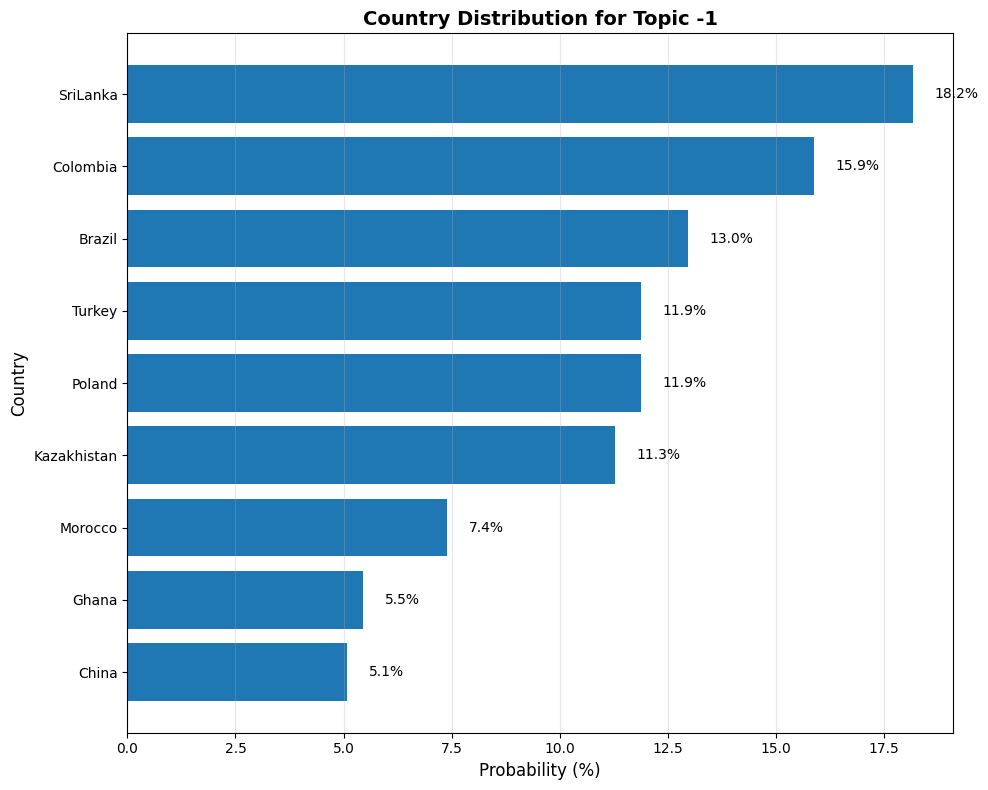


Summary for Topic -1:
Total countries: 9
Top country: SriLanka (18.2%)
Countries shown: 9

Topic -1 distribution:
      Topic      Country  Probability
8   topic-1     SriLanka    18.181818
9   topic-1     Colombia    15.878788
10  topic-1       Brazil    12.969697
11  topic-1       Poland    11.878788
12  topic-1       Turkey    11.878788
13  topic-1  Kazakhistan    11.272727
14  topic-1      Morocco     7.393939
15  topic-1        Ghana     5.454545
16  topic-1        China     5.090909


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have:
# - df: original dataframe with 'Country' column
# - topic_model: your trained BERTopic model
# - topics: topic assignments (usually topic_model.topics_)

# Create a dataframe with topics and countries
topic_country_df = pd.DataFrame({
    'Topic': topics,  # This should be your topic assignments
    'Country': df['Country']  # Original Country column
})

# Calculate the distribution of each topic across countries
topic_country_dist = []

for topic in topic_country_df['Topic'].unique():
    topic_data = topic_country_df[topic_country_df['Topic'] == topic]
    total_docs_in_topic = len(topic_data)
    
    # Calculate percentage for each country within this topic
    country_counts = topic_data['Country'].value_counts()
    
    for country, count in country_counts.items():
        probability = (count / total_docs_in_topic) * 100
        topic_country_dist.append({
            'Topic': f'topic{topic}',
            'Country': country,
            'Probability': probability
        })

# Convert to dataframe
distribution_df = pd.DataFrame(topic_country_dist)

# Display the distribution table
print(distribution_df.head(20))

# Save to Excel if needed
distribution_df.to_excel('topic_country_distribution.xlsx', index=False)

# Plotting function
def plot_topic_country_distribution(topic_num, distribution_df, top_n=20):
    """
    Plot the country distribution for a specific topic as a horizontal bar chart.
    
    Args:
        topic_num: The topic number to plot (e.g., -1, 0, 1, etc.)
        distribution_df: DataFrame with Topic, Country, and Probability columns
        top_n: Number of top countries to display
    """
    # Filter for the specific topic
    topic_name = f'topic{topic_num}'
    topic_data = distribution_df[distribution_df['Topic'] == topic_name].copy()
    
    # Sort by probability in descending order and get top N
    topic_data = topic_data.sort_values('Probability', ascending=True).tail(top_n)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Create horizontal bar chart
    plt.barh(topic_data['Country'], topic_data['Probability'])
    
    # Styling
    plt.xlabel('Probability (%)', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.title(f'Country Distribution for Topic {topic_num}', fontsize=14, fontweight='bold')
    
    # Add value labels on the bars
    for index, value in enumerate(topic_data['Probability']):
        plt.text(value + 0.5, index, f'{value:.1f}%', va='center')
    
    # Add grid for better readability
    plt.grid(axis='x', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for Topic {topic_num}:")
    print(f"Total countries: {len(topic_data)}")
    print(f"Top country: {topic_data.iloc[-1]['Country']} ({topic_data.iloc[-1]['Probability']:.1f}%)")
    print(f"Countries shown: {min(top_n, len(topic_data))}")

# Example usage: Plot distribution for topic -1
plot_topic_country_distribution(-1, distribution_df)

# To see specific topic distributions
print("\nTopic -1 distribution:")
topic_minus_one = distribution_df[distribution_df['Topic'] == 'topic-1'].sort_values('Probability', ascending=False)
print(topic_minus_one.head(10))



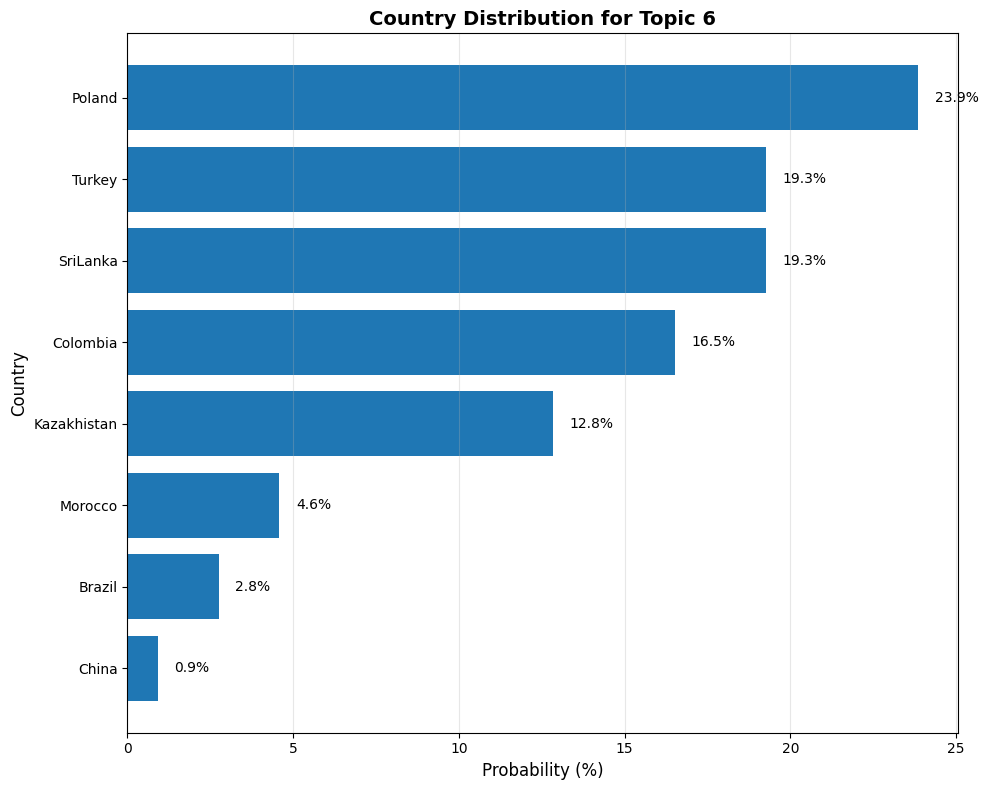


Summary for Topic 6:
Total countries: 8
Top country: Poland (23.9%)
Countries shown: 8

Topic -1 distribution:
      Topic      Country  Probability
8   topic-1     SriLanka    18.181818
9   topic-1     Colombia    15.878788
10  topic-1       Brazil    12.969697
11  topic-1       Poland    11.878788
12  topic-1       Turkey    11.878788
13  topic-1  Kazakhistan    11.272727
14  topic-1      Morocco     7.393939
15  topic-1        Ghana     5.454545
16  topic-1        China     5.090909


In [32]:
# Example usage: Plot distribution for topic -1
plot_topic_country_distribution(6, distribution_df)

# To see specific topic distributions
print("\nTopic -1 distribution:")
topic_minus_one = distribution_df[distribution_df['Topic'] == 'topic-1'].sort_values('Probability', ascending=False)
print(topic_minus_one.head(10))

In [31]:
# Bar Chart
import umap

topic_model.visualize_barchart(
    custom_labels=False, # ignored if none provided
    autoscale=True,
    top_n_topics=100, # arbitrarily high number to make sure all are plotted
    n_words=10,
    width=450,
    title="Top 10 phrases per topic"
    )

In [9]:
# Option 1: Reset the indices to make them sequential
docs_reset = docs.reset_index(drop=True)

# Fit UMAP on embeddings
reduced_embeddings = umap_model.fit_transform(embeddings)

# Now visualize with reset docs
topic_model.visualize_documents(docs_reset, 
                               reduced_embeddings=reduced_embeddings,
                               title="<b>Responses and Topics</b>",
                               hide_annotations=True,
                               width=1800, height=900)


In [10]:
topic_model.visualize_topics()

In [11]:
topic_model.visualize_heatmap()

# Topic Model - OpenAI

In [ ]:
# Define the topic modeling pipeline
import tiktoken
import openai
import numpy as np
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import umap
import hdbscan

# Set global reproducibility seed
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

# UMAP dimensionality reduction
# Reference: https://arxiv.org/pdf/1802.03426
# Implementation: https://umap-learn.readthedocs.io/en/latest/parameters.html#metric
umap_model = umap.UMAP(
    n_components=6,     # tunable: (3 levels: 4-7)
    n_neighbors=15,     # tunable: (4 levels: 10-20)
    min_dist=0.1,       # tunable: (4 levels levels: .01, .3)
    metric='cosine',    
    random_state=seed
) 

# HDBSCAN clustering
# Reference: 
# Implementation:

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples = 1, # 1 minimizes outliers
    metric='euclidean',
    cluster_selection_method='leaf',
    approx_min_span_tree=False, # must be off to have reproducibility
    prediction_data=True
)

# Vectorizer and transformation model
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words="english") # remove stopwords here, but not before the embedding
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Set-up GPT labelling
# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-4o")
# Create your representation model
client = openai.OpenAI(api_key="<your_key>")

from bertopic.representation import OpenAI
import openai
prompt = """
You will extract a short topic label from given documents and keywords. 
*ALL* documents are survey responses to questions about a difficult life decision. Therefore, your goal is to determine a representative, specific, and distinctive label for the documents and keywords within the broader context of difficult life decisions.
Here are two examples of topics you created before for a similar dataset that was not about difficult life decisions:

# Example 1
Sample texts from this topic:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the worst food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

Keywords: meat beef eat eating emissions steak food health processed chicken
topic: Environmental impacts of eating meat

# Example 2
Sample texts from this topic:
- I have ordered the product weeks ago but it still has not arrived!
- The website mentions that it only takes a couple of days to deliver but I still have not received mine.
- I got a message stating that I received the monitor but that is not true!
- It took a month longer to deliver than was advised...

Keywords: deliver weeks product shipping long delivery received arrived arrive week
topic: Shipping and delivery issues

# Your task
Sample texts from this topic:
[DOCUMENTS]

Keywords: [KEYWORDS]

Based on the information above, extract a short topic label (three words at most) in the following format:
topic: <topic_label>"""

gpt = OpenAI(
    client,
    model="gpt-4o",
    delay_in_seconds=3,
    chat=True,
    nr_docs=5,
    doc_length=512,
    tokenizer=tokenizer,
    prompt=prompt
)

from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
mmr = MaximalMarginalRelevance(diversity=.9)
keybertins = KeyBERTInspired(top_n_words=20)

# Use one before GPT
representation_models = {
    # "keybertins":  keybertins,
    "mmr":  mmr,
    "gpt":  gpt,
}


# Define BERTopic model
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=mmr, # mmr for testing OR representation_models if using ChatGPT for topic labelling
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True)
        
        
# Apply topic modeling pipeline
import pandas as pd
import numpy as np


docs = df['Open_Q1_2_en_noQ'].astype(str) # this version of the text, without question text, is used for ctf-idf

# load corresponding precomputed embeddings
emb_data = np.load('./data/Embeddings/Wave 1/ emb_Open_Q1_2_original_noQ_jina-embeddings-v3_ws128_ov64_meanpool.npz')
embeddings = emb_data['embeddings']  # get the actual embeddings, as opposed to the separate ID column


# Fit the BERTopic model to the documents and embeddings
topics, probabilities = topic_model.fit_transform(docs, embeddings) # emb_all_qs_original, emb_Q1_original

# Extract topic-term tf-idf matrix
topic_term_matrix = topic_model.c_tf_idf_

# Construct DataFrame with topic probabilities per document
# pretty sure this doesn't inlucded predicted probabilityes for outlier comments
df_probabilities = pd.DataFrame(probabilities, columns=[f"Topic_{i}" for i in range(probabilities.shape[1])])

# Combine with original comment-level metadata
df = pd.concat([df, df_probabilities], axis=1)

# Optionally save outputs
# df_combined.to_csv("/path/to/output/topic_probabilities.csv", index=False)
# topic_model.save("/path/to/output/bertopic_model", serialization="safetensors", save_ctfidf=True)

# To load a previously saved model
# topic_model = BERTopic.load("/path/to/output/bertopic_model")

In [ ]:
import bertopic

# produce a table where each row is a topic, and each columns records metadata about the topic, like the top phrases, 3 most representative comments, number of comments per topic, etc.
topic_model_summary = topic_model.get_topic_info()

# Function to unnest lists in the Representative_Docs column, placing each comment in its own column
def unnest_comments(row):
    comments = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
    for i, comment in enumerate(comments):
        row[f'comment_{i+1}'] = comment
    return row

# Apply the function to each row in the dataframe
unnested_topic_model_summary = topic_model_summary.apply(unnest_comments, axis=1)

# Drop the original Representative_Docs column
unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])


# Display the result
import pandas as pd

# Define your columns to keep and the new columns to add
cols_to_keep = ['Topic', 'Representation', 'comment_1', 'comment_2', 'comment_3']
label_cols = ['Label_1', 'Label_1_Reason', 'Label_2', 'Label_2_Reason', 'Label_3', 'Label_3_Reason']

# Exclude topic -1
filtered_df = unnested_topic_model_summary[unnested_topic_model_summary['Topic'] != -1]

with pd.ExcelWriter('./data/Embeddings/Wave 1/topic_labeling_pilot.xlsx', engine='openpyxl') as writer:
    for topic in filtered_df['Topic'].unique():
        topic_df = filtered_df[filtered_df['Topic'] == topic][cols_to_keep].copy()
        topic_df = topic_df.rename(columns={'Representation': 'Top_Words'})
        for col in label_cols:
            topic_df[col] = ""
        final_cols = ['Topic', 'Top_Words', 'comment_1', 'comment_2', 'comment_3'] + label_cols
        topic_df = topic_df[final_cols]
        topic_df.to_excel(writer, sheet_name=f"Topic_{topic}", index=False)
        
        
unnested_topic_model_summary.head()       

# turn on if using gpot in representation_models
gpt_list = unnested_topic_model_summary['gpt'].tolist()
for item in gpt_list:
    print(item)



In [ ]:
# --- Topic centroid scoring ---
"""
Compute continuous topic relevance scores for each document.

This function:
1. Identifies the top-N most representative ("central") documents in each topic.
   Centrality can be based on:
     - 'hdbscan': membership strength from HDBSCAN clustering (default)
     - 'probability': BERTopic's topic–document probabilities
     - 'orig_centroid': distance to the full-topic mean embedding
2. Calculates a centroid vector for each topic by averaging the embeddings of its top-N central docs.
3. Uses L2-normalized cosine similarity to score every document against each topic centroid.
4. Appends one new column per topic to the DataFrame, e.g., `topic_0_sim`, `topic_1_sim`, ...
   Higher scores mean the document is more representative of that topic.

Parameters
----------
df : DataFrame
    Your document-level DataFrame.
embeddings : array-like, shape (n_docs, emb_dim)
    Original embeddings for each document (before dimensionality reduction).
topics : array-like, shape (n_docs,)
    Topic assignment for each document (from BERTopic).
topic_model : BERTopic
    Fitted BERTopic model object.
N : int, default=10
    Number of most central documents to use when computing each centroid.
method : {'hdbscan', 'probability', 'orig_centroid'}, default='hdbscan'
    How to determine centrality.
probabilities : array-like, optional
    Topic–document probability matrix from BERTopic (needed if method='probability').
chunk_size : int, optional
    If set, computes similarities in batches to reduce memory usage.
col_prefix, col_suffix : str
    Strings to prepend/append to each similarity column name.

Returns
-------
df_out : DataFrame
    Copy of the input DataFrame with added topic similarity columns.
meta : dict
    Contains 'centroids', 'top_indices', 'topic_order', 'centroid_matrix', and 'similarity_columns'.
"""

import numpy as np
import pandas as pd

def _l2_normalize_rows(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Row-wise L2 normalization with numeric safety."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms

def _topic_centroids_by_centrality(
    topics,
    embeddings: np.ndarray,
    topic_model,
    N: int = 25,
    method: str = "hdbscan",        # "hdbscan", "probability", or "orig_centroid"
    doc_topic_probs: np.ndarray | None = None,
    l2_normalize_before_mean: bool = False,
):
    """
    Compute one centroid per topic by mean-pooling the top-N most central docs.

    Centrality methods:
      - "hdbscan": uses HDBSCAN membership strengths (core-ness) if available.
      - "probability": ranks docs by their soft assignment to each topic (BERTopic probabilities matrix).
      - "orig_centroid": ranks by distance to the full-topic mean in the original embedding space.

    Returns
    -------
    centroids: dict[int, np.ndarray]
    top_indices: dict[int, np.ndarray]
    topic_order: list[int]  (sorted, excludes -1)
    centroid_matrix: np.ndarray  shape=(n_topics, emb_dim)
    """
    labels = np.asarray(topics)
    topic_ids = [t for t in np.unique(labels) if t != -1]

    E = embeddings.copy()
    if l2_normalize_before_mean:
        E = _l2_normalize_rows(E)

    # Build ranking function per method
    if method == "hdbscan":
        hdb = getattr(topic_model, "hdbscan_model_", None) or getattr(topic_model, "hdbscan_model", None)
        if hdb is None or not hasattr(hdb, "probabilities_"):
            raise ValueError("HDBSCAN probabilities not found. Use method='probability' (pass `probabilities`) or 'orig_centroid'.")
        membership = np.asarray(hdb.probabilities_)
        def rank(idx, _t=None):  # higher = more central
            return idx[np.argsort(membership[idx])[::-1]]

    elif method == "probability":
        P = doc_topic_probs if doc_topic_probs is not None else getattr(topic_model, "probabilities_", None)
        if P is None:
            raise ValueError("Doc-topic probabilities not provided. Pass `doc_topic_probs=probabilities` from fit_transform.")
        P = np.asarray(P)
        # Map topic IDs to probability columns
        valid_sorted = sorted(topic_ids)
        if P.shape[1] != len(valid_sorted):
            info = topic_model.get_topic_info()
            order = [int(t) for t in info.loc[info["Topic"] != -1, "Topic"].tolist()]
            topic_to_col = {t: i for i, t in enumerate(order)} if len(order) == P.shape[1] else {t: i for i, t in enumerate(valid_sorted)}
        else:
            topic_to_col = {t: i for i, t in enumerate(valid_sorted)}
        def rank(idx, t):
            col = topic_to_col[t]
            return idx[np.argsort(P[idx, col])[::-1]]

    elif method == "orig_centroid":
        def rank(idx, _t=None):     # closer to cluster mean = more central
            cluster = E[idx]
            center = cluster.mean(axis=0, keepdims=True)
            d = np.linalg.norm(cluster - center, axis=1)
            return idx[np.argsort(d)]
    else:
        raise ValueError("`method` must be 'hdbscan', 'probability', or 'orig_centroid'.")

    centroids, top_indices = {}, {}
    for t in topic_ids:
        idx = np.where(labels == t)[0]
        if idx.size == 0:
            continue
        chosen = rank(idx, t)[: min(N, idx.size)]
        top_indices[t] = chosen
        centroids[t] = E[chosen].mean(axis=0)

    topic_order = sorted(centroids.keys())
    centroid_matrix = np.vstack([centroids[t] for t in topic_order]) if topic_order else np.empty((0, E.shape[1]))
    return centroids, top_indices, topic_order, centroid_matrix

def _centroid_sim_matrix(
    embeddings: np.ndarray,
    centroid_matrix: np.ndarray,
    chunk_size: int | None = None,
    dtype=np.float32,
) -> np.ndarray:
    """Cosine similarities of each doc to each centroid. Returns (n_docs x n_topics)."""
    E = _l2_normalize_rows(embeddings.astype(dtype, copy=False))
    C = _l2_normalize_rows(centroid_matrix.astype(dtype, copy=False))
    if chunk_size is None:
        return E @ C.T
    sims = np.empty((E.shape[0], C.shape[0]), dtype=dtype)
    for s in range(0, E.shape[0], chunk_size):
        e = min(s + chunk_size, E.shape[0])
        sims[s:e] = E[s:e] @ C.T
    return sims

def score_docs_by_topic_centroids(
    df: pd.DataFrame,
    embeddings: np.ndarray,
    topics,
    topic_model,
    N: int = 10,
    method: str = "hdbscan",
    probabilities: np.ndarray | None = None,
    chunk_size: int | None = None,
    col_prefix: str = "topic_",
    col_suffix: str = "_sim",
):
    """
    High-level helper: compute centroids (top-N central docs) and append cosine
    similarity scores to `df` as columns like 'topic_12_sim'.

    Returns
    -------
    df_out: DataFrame with new similarity columns
    meta: dict with keys { 'centroids', 'top_indices', 'topic_order', 'centroid_matrix' }
    """
    centroids, top_idx, topic_order, centroid_mat = _topic_centroids_by_centrality(
        topics=topics,
        embeddings=embeddings,
        topic_model=topic_model,
        N=N,
        method=method,
        doc_topic_probs=probabilities,
        l2_normalize_before_mean=False,
    )

    sims = _centroid_sim_matrix(embeddings, centroid_mat, chunk_size=chunk_size)
    sim_cols = [f"{col_prefix}{t}{col_suffix}" for t in topic_order]

    df_out = pd.concat([df, pd.DataFrame(sims, columns=sim_cols, index=df.index)], axis=1)
    meta = {
        "centroids": centroids,
        "top_indices": top_idx,
        "topic_order": topic_order,
        "centroid_matrix": centroid_mat,
        "similarity_columns": sim_cols,
    }
    return df_out, meta

# --- Example usage (minimal) ---
df_scored, meta = score_docs_by_topic_centroids(
    df=df,
    embeddings=embeddings,
    topics=topics,
    topic_model=topic_model,
    N=10,
    method="hdbscan",          # or "probability" (pass probabilities=probabilities), or "orig_centroid"
)
df_scored[meta["similarity_columns"]].head()
